https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

In [48]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re, string
import nltk
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


In [49]:
# In this verrsion I introduced some common Swahili stop words
stop_words_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/swahili_stopwords.csv')
stop_words = stop_words_df['StopWords'].tolist()

In [50]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Train.csv')
df.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: category, dtype: int64


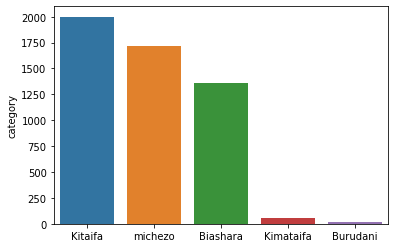

In [51]:
x=df['category'].value_counts()
print(x)
sns.barplot(x.index,x)

Pre-Processing

In [52]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

In [53]:
def finalpreprocess(string):
    return stopword(preprocess(string))

In [54]:
df['clean_text'] = df['content'].apply(lambda x: finalpreprocess(x))

In [55]:
df.head()

,id,content,category,clean_text
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,serikali imesema haitakuwa tayari kuona amani ...
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,mkuu mkoa tabora aggrey mwanri amesitisha liki...
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,serikali imetoa miezi sita taasisi zote umma a...
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,kampuni mchezo kubahatisha m bet imeingia maku...
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,watanzania wamekumbushwa kusherehekea sikukuu ...


Vectorization

In [56]:
#Splitting the dataset into Train and Test 'groups'
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["category"],test_size=0.2,shuffle=True)

In [57]:
#Tf-Idf Vectorization
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

## Modeling

Logical Regression

In [58]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 

              precision    recall  f1-score   support

    Biashara       0.85      0.78      0.81       272
    Burudani       0.00      0.00      0.00         1
   Kimataifa       0.00      0.00      0.00        12
     Kitaifa       0.82      0.88      0.85       411
     michezo       0.96      0.97      0.96       335

    accuracy                           0.87      1031
   macro avg       0.53      0.53      0.53      1031
weighted avg       0.86      0.87      0.87      1031

Confusion Matrix: [[211   0   0  60   1]
 [  0   0   0   1   0]
 [  0   0   0  11   1]
 [ 36   0   0 363  12]
 [  0   0   0  10 325]]


Naive Bayes

In [59]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 

              precision    recall  f1-score   support

    Biashara       0.91      0.39      0.55       272
    Burudani       0.00      0.00      0.00         1
   Kimataifa       0.00      0.00      0.00        12
     Kitaifa       0.65      0.95      0.77       411
     michezo       0.96      0.90      0.93       335

    accuracy                           0.77      1031
   macro avg       0.51      0.45      0.45      1031
weighted avg       0.81      0.77      0.75      1031

Confusion Matrix: [[106   0   0 166   0]
 [  0   0   0   1   0]
 [  0   0   0  11   1]
 [ 10   0   0 391  10]
 [  0   0   0  33 302]]


Creating Submission File

In [60]:
dftest = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Test.csv')

In [61]:
dftest['clean_text'] = dftest['content'].apply(lambda x: preprocess(x))

In [62]:
X_test2 = dftest['clean_text']

In [63]:
X_vector2 = tfidf_vectorizer.transform(X_test2)

In [64]:
#use the best model to predict 'target' value for the new dataset 
y_predict2 = lr_tfidf.predict(X_vector2)      
y_prob2 = lr_tfidf.predict_proba(X_vector2)[:,1]
dftest['predict_prob']= y_prob2
dftest['category']= y_predict2
final=dftest[['clean_text','category']].reset_index(drop=True)
print(final.head())

                                          clean_text  category
0  mkuu wa wilaya ya bahi mkoani dodoma mwanahami...   Kitaifa
1  mwishoni mwa wiki hii timu ya soka ya taifa ta...   michezo
2  thamani ya mauzo ya bidhaa za afrika mashariki...  Biashara
3  meneja mawasiliano na utetezi wa asasi ya agpa...   Kitaifa
4  waziri wa kilimo japhet hasunga amesema serika...   Kitaifa


In [47]:
dftest

,swahili_id,content,clean_text,predict_prob,category
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah...",mkuu wa wilaya ya bahi mkoani dodoma mwanahami...,0.001092,Kitaifa
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,...",mwishoni mwa wiki hii timu ya soka ya taifa ta...,0.000383,michezo
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...,thamani ya mauzo ya bidhaa za afrika mashariki...,0.001436,Biashara
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...,meneja mawasiliano na utetezi wa asasi ya agpa...,0.003320,Kitaifa
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri...",waziri wa kilimo japhet hasunga amesema serika...,0.002563,Kitaifa
...,...,...,...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,MKURUGENZI Msaidizi Msajili wa Asasi za kirai...,mkurugenzi msaidizi msajili wa asasi za kirai ...,0.001445,Kitaifa
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,Kilomoni alisema jana kesho atazungumzia sual...,kilomoni alisema jana kesho atazungumzia suala...,0.001516,michezo
1285,feed09e13586d12139cd59bc20996a4d29706606,"TIMU ya taifa ya soka ya Tanzania Bara, Kilim...",timu ya taifa ya soka ya tanzania bara kiliman...,0.000953,michezo
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"YANGA imetozwa faini ya Sh 3,500,000 kutokana...",yanga imetozwa faini ya sh kutokana na makosa ...,0.000461,michezo


In [46]:
type(final)

pandas.core.frame.DataFrame